In [1]:
import torch
import matplotlib.pyplot as plt
import glob
from utils import imageSize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter


In [2]:

# Assuming you want to create a DataLoader for image datasets
transform = transforms.Compose([
    transforms.Resize((imageSize, imageSize)),
    transforms.ToTensor()
])

# Create a dataset and dataloader
dataset = datasets.ImageFolder('data', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
val_size = test_size // 2
test_size = test_size - val_size
batch_size = 32
train_dataset,val_dataset ,test_dataset = random_split(dataset, [train_size, val_size,test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [3]:
clases = dataset.classes
classes =[longClass.split('-')[0] for longClass in dataset.classes]

In [4]:
@torch.no_grad()
def showImages(images,labels,predLabels=None):
    fig = plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        tlt = classes[labels[i]] if predLabels is None else f'Target: {classes[labels[i]]} \nPrediction{classes[predLabels[i]]}'
        plt.title(tlt)
        plt.axis('off')
    return fig

In [5]:
images, labels = next(iter(val_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


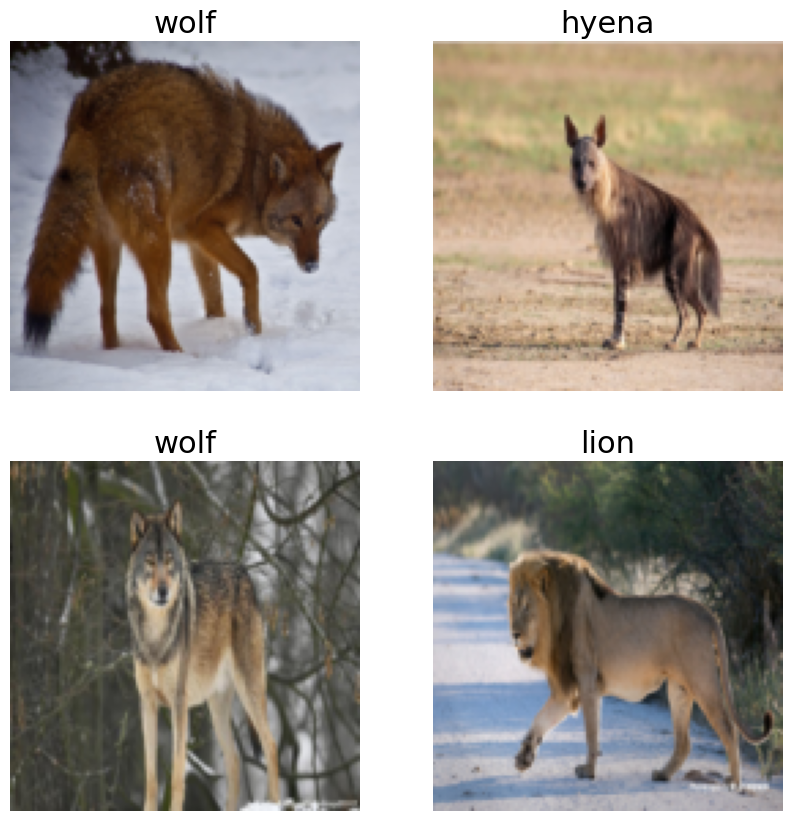

In [6]:
_ = showImages(images, labels)

# Create model

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(2, 2) if pool else None

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        if self.pool is not None:
            x = self.pool(x)
        return x

In [8]:
class animalModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.flatten = nn.Flatten()
        modifier = imageSize//2**3
        self.fc1 = nn.Linear(512*modifier*modifier, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
class convBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, pool=False, dropout=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if pool else None
        self.dropout = nn.Dropout(0.3) if dropout else None

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        if self.pool is not None:
            x = self.pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        return x

In [ ]:
class Animal2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = convBlock2(in_channels, 64)
        self.conv2 = convBlock2(64, 64, pool=True,dropout=True)
        self.conv3 = convBlock2(64, 64, pool=True,dropout=True)
        self.conv4 = convBlock2(64, 64, pool=True,dropout=True)
        #self.conv5 = convBlock2(64, 64, pool=True,dropout=True)
        self.flatten = nn.Flatten()
        modifier = imageSize//2**3
        
        self.fc1 = nn.Linear(64*modifier*modifier, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        #self.fc2 = nn.Linear(256, 128)
        #self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.3)

        #self.fc3 = nn.Linear(128, 128)
        #self.act3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.3)
        self.outp = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        #x = self.fc2(x)
        #x = self.act2(x)
        #x = self.dropout2(x)

        #x = self.fc3(x)
        #x = self.act3(x)
        #x = self.dropout3(x)

        x = self.outp(x)
        x = self.softmax(x)
        return x

In [11]:
num_classes = len(classes)  
model = Animal2(3, num_classes)
num_epochs = 40
valSteps = len(val_loader)
writer = SummaryWriter()
lossF = nn.CrossEntropyLoss()
learningRate = 1e-3
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=momentum)
accMetric = Accuracy(task='multiclass',num_classes=num_classes)
writer.add_hparams({'lr':learningRate,'optim':'SGD','Batch Size':batch_size,'Number of epochs':num_epochs,'momentum':momentum,'image size':imageSize},{'hparam/accuracy':0.0})

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainsteps  = len(train_loader)


In [13]:
model = model.to(device)
writer.add_graph(model, images.to(device))
accMetric.to(device)
for epoch in range(num_epochs):
    print('Epoch:', epoch)
    model.train()
    train_loss = 0.0
    train_accs = 0.0
    val_accs = 0.0
    val_losses = 0.0
    for trainingStep, (images, labels) in enumerate(train_loader):
        print(trainingStep,end='\r')
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = lossF(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        writer.add_scalar('Loss/train_step', loss, epoch*trainsteps+trainingStep)
        
        preds = torch.argmax(outputs, dim=1)
        train_acc = accMetric(preds, labels)
        train_accs += train_acc

        writer.add_scalar('Accuracy/train_step', train_acc, epoch*trainsteps+trainingStep)
    
    writer.add_scalar('Loss/train_epoch', train_loss/trainsteps, epoch)
    writer.add_scalar('Accuracy/train_epoch', train_accs/trainsteps, epoch)
    print(f'Training Loss: {train_loss/trainsteps} Training Accuracy: {train_accs/trainsteps}')
    for valStep, (images,labels) in enumerate(val_loader):
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            val_acc = accMetric(preds, labels)
            val_accs += val_acc
            val_loss = lossF(outputs, labels)
            val_losses += val_loss
        writer.add_scalar('Accuracy/val_step', val_acc, epoch*valSteps+valStep)
        writer.add_scalar('Loss/val_step', val_loss, epoch*valSteps+valStep)
    writer.add_scalar('Accuracy/val_epoch', val_acc, epoch)
    writer.add_scalar('Loss/val_epoch', loss, epoch)
    print(f'Validation Loss: {val_losses/valSteps} Validation Accuracy: {val_accs/valSteps}')

Epoch: 0
Training Loss: 1.7808286195451564 Training Accuracy: 0.203125
Validation Loss: 1.7565956115722656 Validation Accuracy: 0.2256944477558136
Epoch: 1
Training Loss: 1.7243289297277278 Training Accuracy: 0.3025568127632141
Validation Loss: 1.6856861114501953 Validation Accuracy: 0.3732638955116272
Epoch: 2
Training Loss: 1.639119958335703 Training Accuracy: 0.42116478085517883
Validation Loss: 1.6346791982650757 Validation Accuracy: 0.4496527910232544
Epoch: 3
Training Loss: 1.598854812708768 Training Accuracy: 0.4630681872367859


KeyboardInterrupt: 